In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets

opendatasets.download('https://www.kaggle.com/datasets/samaneheslamifar/facial-emotion-expressions')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saiharshithakomati
Your Kaggle Key: ··········


100%|██████████| 121M/121M [00:01<00:00, 84.2MB/s]


In [ ]:
#Import required libraries

import os
import cv2
import random
import datetime
import imutils
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
data = []
labels = []
imagePaths = []

images_path = "/content/facial-emotion-expressions/images"
sub_path = ["train","validation"]

classes_train = os.listdir(images_path + "/train")
classes_valid = os.listdir(images_path + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

Train Classes - ['disgust', 'neutral', 'happy', 'surprise', 'fear', 'sad', 'angry']
Validation Classes - ['disgust', 'neutral', 'happy', 'surprise', 'fear', 'sad', 'angry']


In [ ]:
train_path = Path(images_path+"/train")
valid_path = Path(images_path+"/validation")

In [ ]:
batch_size = 100
epochs = 40
img_channel = 3
img_width, img_height = (64,64)
train_dataset_main = images_path + "/train"
valid_dataset_main = images_path + "/validation"

In [ ]:
def create_dataset_df(main_path, dataset_name):
    df = {"image_path":[],"class_label":[]}
    for class_label in os.listdir(main_path):
            for image_path in glob.glob(f"{main_path}/{class_label}/*"):
                df["image_path"].append(image_path)
                df["class_label"].append(class_label)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

In [ ]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

Train dataset is created !


In [ ]:
valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

Validation dataset is created !


In [ ]:
print(f"train samples: {len(train_df)} \nvalidation samples: {len(valid_df)}")

train samples: 28821 
validation samples: 7066


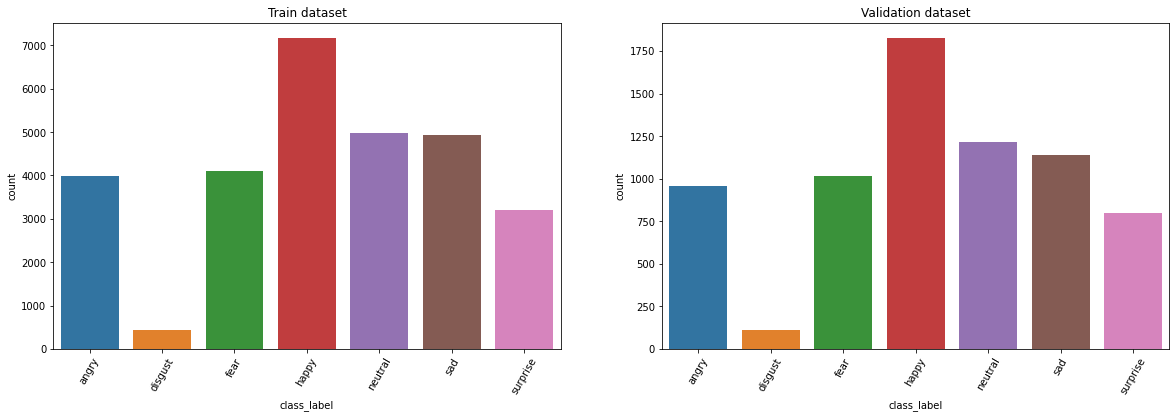

In [ ]:
plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_label",),x="class_label")
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_label"),x="class_label")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

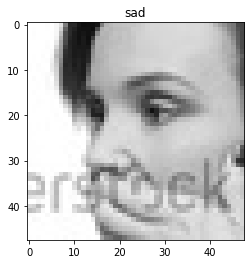

In [ ]:
index = np.random.randint(0, len(train_df))
img = cv2.imread(train_df.image_path[index])
class_name = train_df.class_label[index]
imgplot = plt.imshow(img.astype('uint8'))
plt.title(class_name)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_label"] = Le.fit_transform(train_df["class_label"])

train_df["class_label"].value_counts()

3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: class_label, dtype: int64

In [ ]:
valid_df["class_label"] = Le.fit_transform(valid_df["class_label"])

In [ ]:
#One Hot encoding
train_labels = tf.keras.utils.to_categorical(train_df["class_label"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_label"])

In [ ]:
classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7941397, 1: 16.431192, 2: 1.7460395, 3: 1.0, 4: 1.4379767, 5: 1.4507898, 6: 2.2352574}


In [ ]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 64

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.2, -0.02))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of its CPU budget across all parameters
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Creating Train Dataset object and Verifying it 
train_dataset = get_dataset(train_df["image_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)

(64, 96, 96, 3)
(64, 7)


neutral


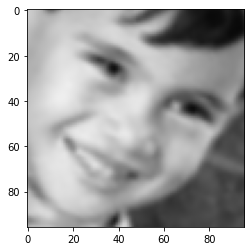

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))
plt.show()

In [ ]:
val_dataset = get_dataset(valid_df["image_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(64, 96, 96, 3)
(64, 7)


neutral


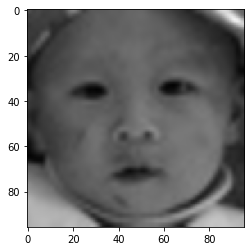

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))
plt.show()

In [ ]:
model_1 = Sequential([
    layers.Rescaling(1./255,input_shape=(96,96,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48,3,padding='same',activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [ ]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 48)       

In [127]:
def loss_graph(model):
  labelNames = ["loss"]
  P = np.arange(0,epochs)
  plt.style.use('dark_background')
  plt.figure(figsize=(20,12))
  plt.style.use('dark_background')
  plt.figure(figsize=(20,12))
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch No")
  plt.ylabel("Loss")
  plt.plot(P, model.history["loss"],label="loss")
  plt.plot(P, model.history["val_loss"],label="val_loss")
  plt.legend()
  plt.show()

In [ ]:
def compare_accuracy(model):
  labelNames = ["loss"]
  P = np.arange(0,epochs)
  plt.style.use('dark_background')
  plt.figure(figsize=(20,12))
  plt.style.use('dark_background')
  plt.figure(figsize=(20,12))
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epoch No")
  plt.ylabel("Accuracy")
  plt.plot(P, model.history["accuracy"],label="acc")
  plt.plot(P, model.history["val_accuracy"],label="val_acc")
  plt.legend()
  plt.show()

In [ ]:
model_1.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy' ]
)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")

In [ ]:
epochs = 10
cnn_model_1 = model_1.fit(train_dataset,
                          steps_per_epoch=len(train_labels)//BATCH_SIZE,
                          epochs=epochs,
                          validation_data=val_dataset,
                          validation_steps = len(valid_labels)//BATCH_SIZE,
                          class_weight=class_weight)

Epoch 1/10
450/450 [==============================] - 353s 783ms/step - loss: 2.0689 - accuracy: 0.6992 - val_loss: 10.5704 - val_accuracy: 0.1338
Epoch 2/10
450/450 [==============================] - 352s 784ms/step - loss: 2.3152 - accuracy: 0.6325 - val_loss: 5.3520 - val_accuracy: 0.1339
Epoch 3/10
450/450 [==============================] - 370s 822ms/step - loss: 2.0347 - accuracy: 0.6575 - val_loss: 6.7480 - val_accuracy: 0.1341
Epoch 4/10
450/450 [==============================] - 349s 775ms/step - loss: 2.2363 - accuracy: 0.6599 - val_loss: 3.5117 - val_accuracy: 0.1339
Epoch 5/10
450/450 [==============================] - 350s 777ms/step - loss: 1.5610 - accuracy: 0.7243 - val_loss: 7.1375 - val_accuracy: 0.1344
Epoch 6/10
450/450 [==============================] - 348s 772ms/step - loss: 1.9352 - accuracy: 0.7039 - val_loss: 8.1832 - val_accuracy: 0.1341
Epoch 7/10
450/450 [==============================] - 371s 825ms/step - loss: 1.8735 - accuracy: 0.7111 - val_loss: 14.8999

<Figure size 1440x864 with 0 Axes>

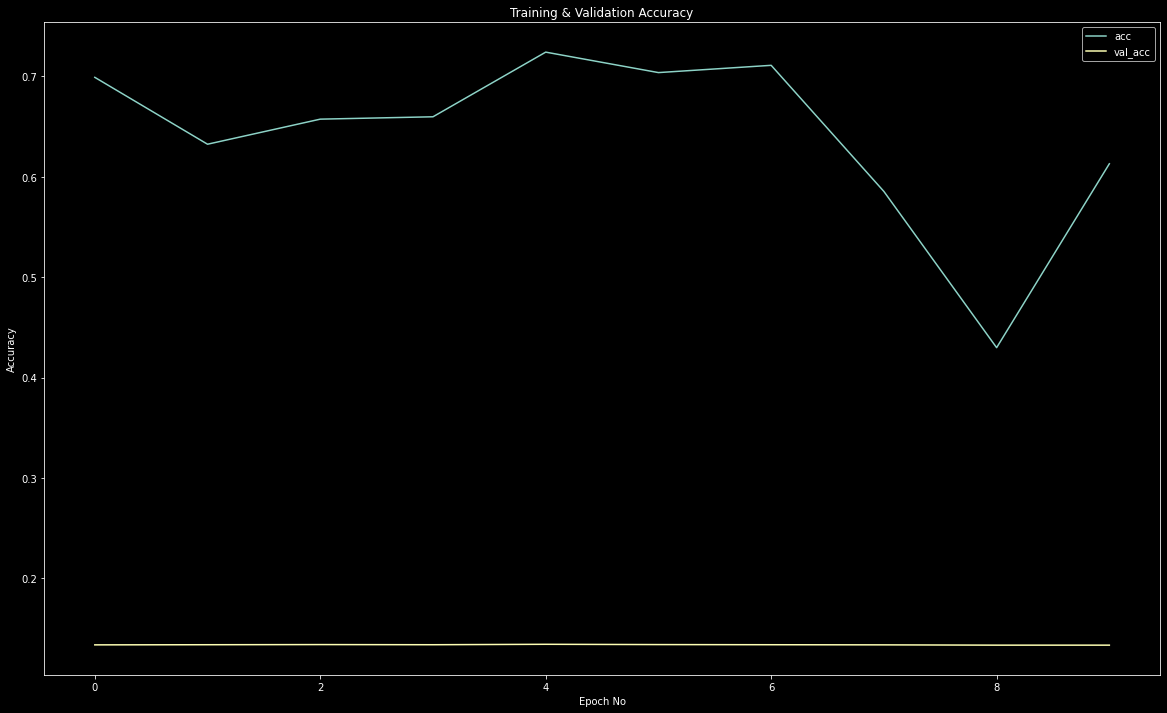

In [ ]:
compare_accuracy(cnn_model_1)

In [ ]:
model_3 = Sequential()
model_3.add(Convolution2D(64, (5, 5), activation='relu', input_shape=(96,96,3)))
model_3.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model_3.add(Convolution2D(64, (3, 3), activation='relu'))
model_3.add(Convolution2D(64, (3, 3), activation='relu'))
model_3.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model_3.add(Convolution2D(128, (3, 3), activation='relu'))
model_3.add(Convolution2D(128, (3, 3), activation='relu'))
model_3.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model_3.add(Flatten())

#fully connected neural networks
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.2))

model_3.add(Dense(7, activation='softmax'))

In [ ]:
model_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 92, 92, 64)        4864      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 44, 44, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 42, 42, 64)        36928     
                                                                 
 conv2d_118 (Conv2D)         (None, 40, 40, 64)        36928     
                                                                 
 average_pooling2d_2 (Averag  (None, 19, 19, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_119 (Conv2D)         (None, 17, 17, 128)     

In [ ]:
model_3.compile(
    optimizer=Adam(),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' ]
)

In [ ]:
epochs = 5
cnn_model_3 = model_3.fit(train_dataset,
                          steps_per_epoch=len(train_labels)//(BATCH_SIZE*10),
                          epochs=epochs,
                          validation_data=val_dataset,
                          validation_steps = len(valid_labels)//(BATCH_SIZE*10),
                          class_weight=class_weight)

Epoch 1/5
45/45 [==============================] - 199s 4s/step - loss: 8.0745 - accuracy: 0.4837 - val_loss: 2.0704 - val_accuracy: 0.8210
Epoch 2/5
45/45 [==============================] - 190s 4s/step - loss: 1.1632 - accuracy: 0.8090 - val_loss: 1.0672 - val_accuracy: 0.0952
Epoch 3/5
45/45 [==============================] - 180s 4s/step - loss: 0.4173 - accuracy: 0.8576 - val_loss: 4.4424 - val_accuracy: 0.0909
Epoch 4/5
45/45 [==============================] - 180s 4s/step - loss: 0.0415 - accuracy: 0.9958 - val_loss: 6.2232 - val_accuracy: 0.0866
Epoch 5/5
45/45 [==============================] - 180s 4s/step - loss: 1.4136 - accuracy: 0.7635 - val_loss: 6.6269 - val_accuracy: 0.0000e+00


<Figure size 1440x864 with 0 Axes>

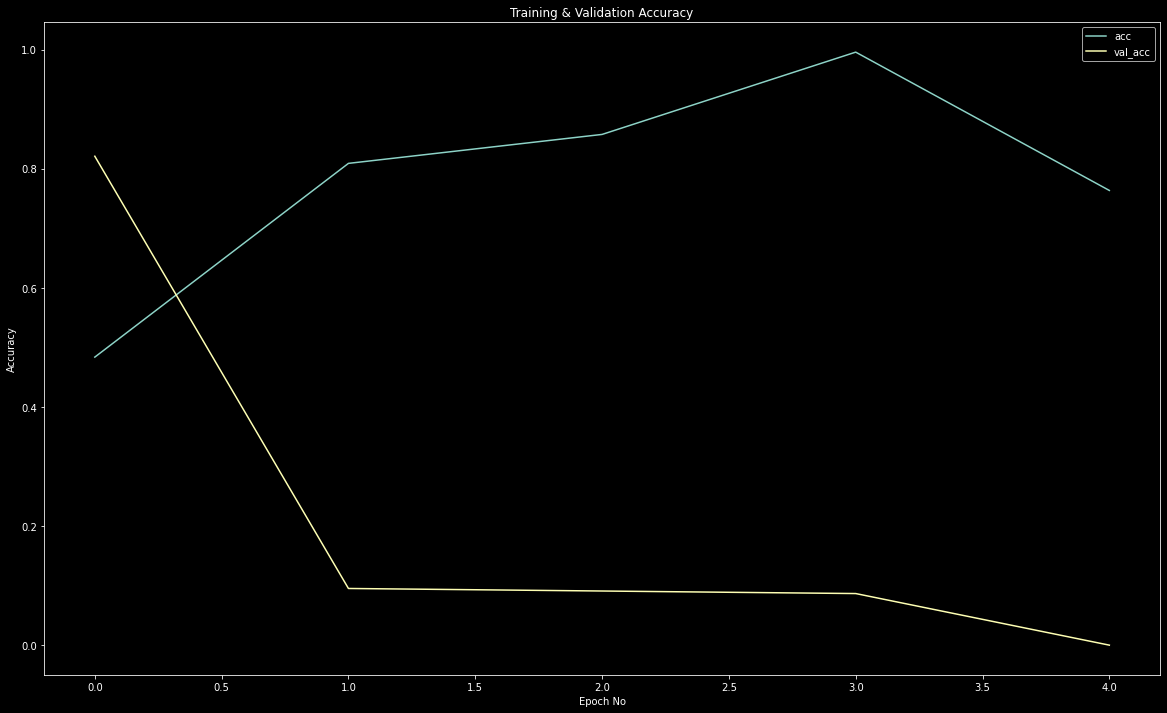

In [122]:
compare_accuracy(cnn_model_3)

In [ ]:
model_2 = Sequential()
model_2.add(ZeroPadding2D((1,1),input_shape=(96,96, 3)))
model_2.add(Convolution2D(64, (3, 3),padding = 'Same',activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(64, (3, 3),padding = 'Same', activation='relu'))
model_2.add(MaxPooling2D((2,2), strides=(2,2)))

model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(128, (3, 3),padding = 'Same', activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(128, (3, 3),padding = 'Same', activation='relu'))
model_2.add(MaxPooling2D((2,2), strides=(2,2)))

model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(256, (3, 3),padding = 'Same', activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(256, (3, 3),padding = 'Same', activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(256, (3, 3),padding = 'Same', activation='relu'))
model_2.add(MaxPooling2D((2,2), strides=(2,2)))

model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(512, (3, 3),padding = 'Same', activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(512, (3, 3),padding = 'Same', activation='relu'))
model_2.add(ZeroPadding2D((1,1)))
model_2.add(Convolution2D(512, (3, 3),padding = 'Same', activation='relu'))
model_2.add(MaxPooling2D((2,2), strides=(2,2)))

model_2.add(Flatten())

model_2.add(Dense(7,activation='softmax'))

In [ ]:
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_88 (ZeroPadd  (None, 98, 98, 3)        0         
 ing2D)                                                          
                                                                 
 conv2d_101 (Conv2D)         (None, 98, 98, 64)        1792      
                                                                 
 zero_padding2d_89 (ZeroPadd  (None, 100, 100, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_102 (Conv2D)         (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
model_2.compile(
    optimizer=Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' ]
)

In [ ]:
epochs = 5
cnn_model_2 = model_2.fit(train_dataset,
                          steps_per_epoch=len(train_labels)//(BATCH_SIZE*10),
                          epochs=epochs,
                          validation_data=val_dataset,
                          validation_steps = len(valid_labels)//(BATCH_SIZE*10),
                          class_weight=class_weight)

Epoch 1/5
45/45 [==============================] - 2270s 50s/step - loss: 2.0464 - accuracy: 0.4778 - val_loss: 1.3163 - val_accuracy: 0.8253
Epoch 2/5
45/45 [==============================] - 2142s 48s/step - loss: 1.1188 - accuracy: 0.8198 - val_loss: 1.4996 - val_accuracy: 0.0824
Epoch 3/5
45/45 [==============================] - 2141s 48s/step - loss: 0.4281 - accuracy: 0.9049 - val_loss: 4.7648 - val_accuracy: 0.0866
Epoch 4/5
45/45 [==============================] - 2143s 48s/step - loss: 0.0450 - accuracy: 0.9958 - val_loss: 6.3765 - val_accuracy: 0.0938
Epoch 5/5
45/45 [==============================] - 2143s 48s/step - loss: 1.6467 - accuracy: 0.7524 - val_loss: 5.8987 - val_accuracy: 0.0000e+00


<Figure size 1440x864 with 0 Axes>

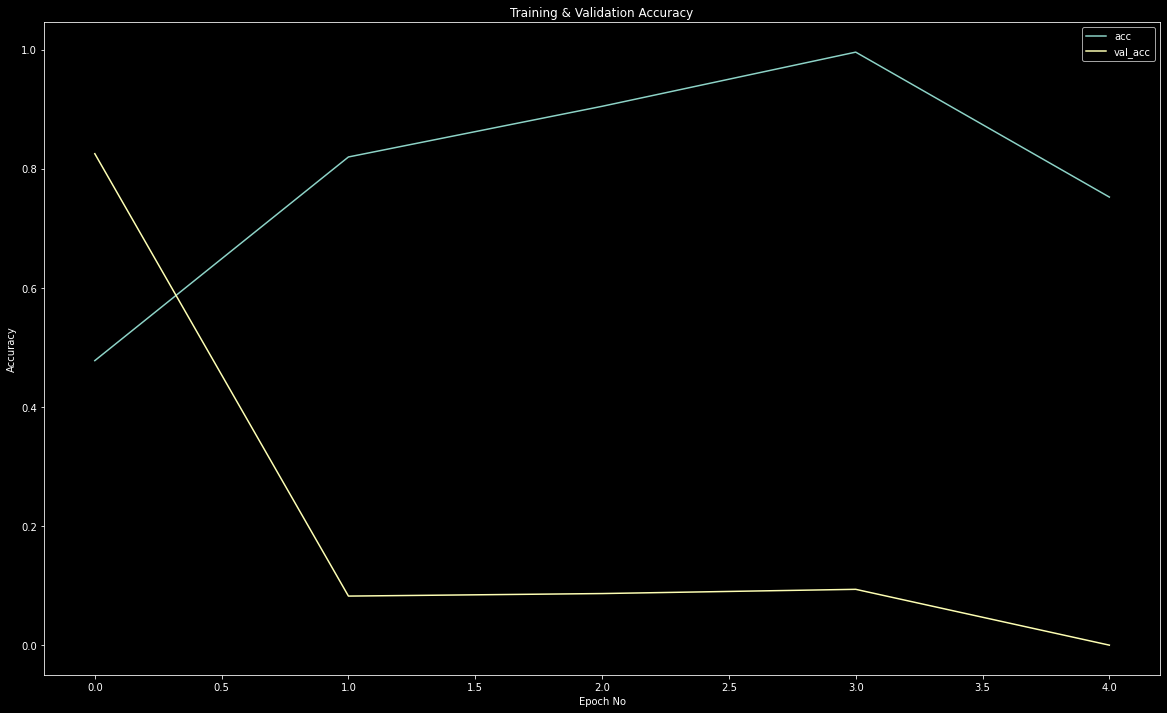

In [124]:
compare_accuracy(cnn_model_2)

In [137]:
models = ["Model 1", "Model 2", "Model 3"]
accuracies = [100*cnn_model_1.history["accuracy"][-1],100*cnn_model_2.history["accuracy"][-1],100*cnn_model_3.history["accuracy"][-1]]

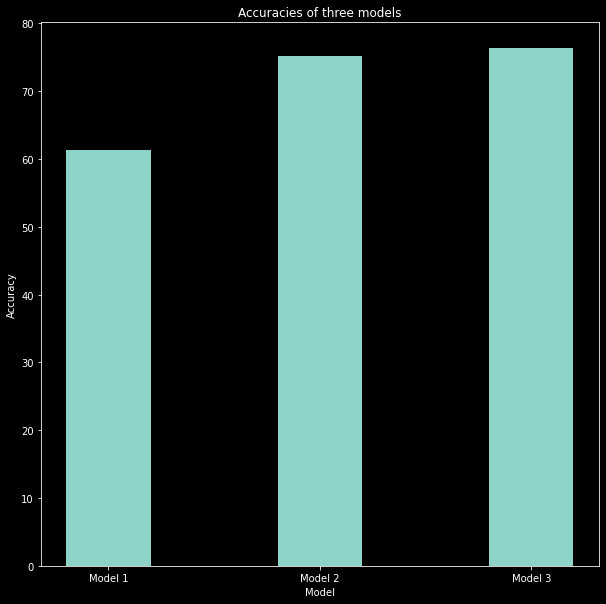

In [138]:
fig = plt.figure(figsize=(10,10))
plt.bar(models,accuracies,width=0.4)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracies of three models")
plt.show()